# Machinations to CadCAD conversion guide 2
## for AMM model

Here's the link to the machinations model by Mathew Morris:
https://machinations.io/community/matthew.16/webinar-simplified-example-token-side-amm-ccff2f0fe9a111ec8c2902f943517e50/

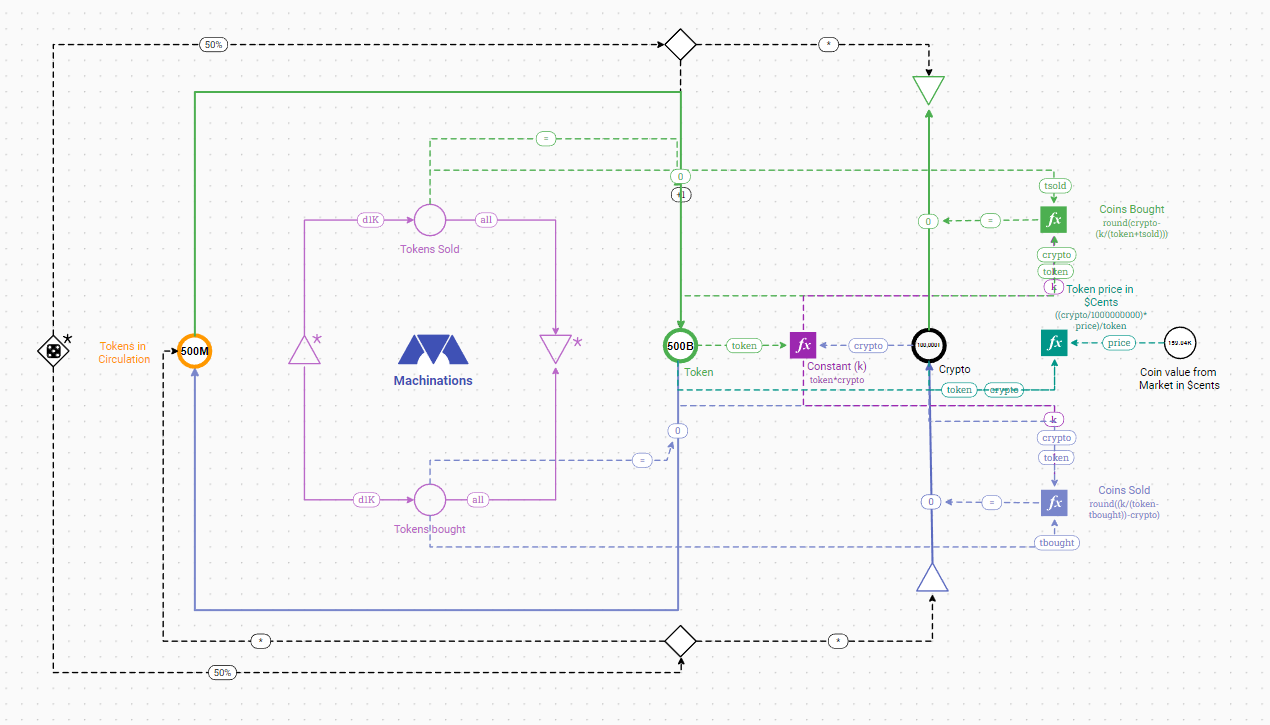

## Importing libraries

In [474]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
pd.options.plotting.backend = "plotly"
import plotly.io as pio
pio.templates.default = "seaborn"
from dataclasses import dataclass
import copy
from dataclasses import field
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

## Defining the types of variables

In [475]:
TOKENS = int
PERCENTAGE = float
CENTS = int

## Defining the System Params

In [476]:
#utils
def default(obj):
    return field(default_factory=lambda: copy.copy(obj))


@dataclass
class Parameters:
    # crash_chance is the chance of crashing in the beginning
    initial_tokens_circulating: PERCENTAGE = default([500000])


# Initialize Parameters instance with default values
system_params = Parameters().__dict__


## State Variables

In [500]:

@dataclass
class StateVariables:
    tokens: TOKENS = 500000000000
    crypto: TOKENS = 100000000000000000
    tokens_sold: TOKENS = 0
    tokens_bought: TOKENS = 0
    tokens_in_circulation: TOKENS = 500000
    coin_market_value: CENTS = 159040
    price : CENTS = 31.8

initial_state = StateVariables().__dict__

## Policy Functions

We can break the policies down into mechanism and behavior policies

In [501]:
## Behavior policies

def p_amount_bought_or_sold(params, substep, state_history, prev_state, **kwargs):
    '''policy that decides whether tokens are bought or sold in the block'''

    if random.random()< 0.5:
        token_buy = random.randint(0,1000)
        token_sell = 0
    else:
        token_sell = random.randint(0,1000)
        token_buy = 0

    # much better ways to do this like just having randint(-1000,1000) and assuming negative means bought, positive means sold
    # but let's stick to doing it the way the model has done it
    
    return {'tbought': token_buy, 'tsold': token_sell}


## Mechanism policies 

def p_amount_of_coins(params, substep, state_history, prev_state, **kwargs):
    '''amount of coins to update'''

    k = prev_state['crypto'] * prev_state['tokens']

    if prev_state['tokens_sold'] >0:
        amount_coins_added = 0
        amount_coins_removed=np.round(prev_state['crypto'] - (k/(prev_state['tokens'] + prev_state['tokens_sold'])))

    elif prev_state['tokens_bought'] >0:
        amount_coins_removed = 0
        amount_coins_added = np.round((k/(prev_state['tokens'] - prev_state['tokens_bought'])) - prev_state['crypto'])

    else:
        amount_coins_added =0
        amount_coins_removed=0

    return {'amount_coins_added': amount_coins_added, 'amount_coins_removed': amount_coins_removed}

def p_price(params, substep, state_history, prev_state, **kwargs):
        '''Calculates the price '''
        new_price=(prev_state['crypto']/ prev_state['tokens'])*prev_state['coin_market_value']/1000000000

        return {'price': new_price}

# ((crypto/1000000000)*price)/token

## State Update Functions and Partial State Update Blocks

In [502]:



def s_update_tokens_sold(params, substep, state_history, prev_state, policy_input, **kwargs):
        '''Update the tokens sold'''
        updated_tokens_sold = np.round(policy_input['tsold'])
        return ('tokens_sold', max(updated_tokens_sold, 0))

def s_update_tokens_bought(params, substep, state_history, prev_state, policy_input, **kwargs):
        '''Update the state of the difficulty variable by the amount of difficulty increase'''

        updated_tokens_bought = np.round(policy_input['tbought'])
        return ('tokens_bought', max(updated_tokens_bought, 0))


#############################


def s_update_tokens(params, substep, state_history, prev_state, policy_input, **kwargs):
        '''Update the state of the distance variable by the amount of distance sprinted'''
        updated_tokens = np.round(prev_state['tokens'] + prev_state['tokens_sold'] - prev_state['tokens_bought'])

        return ('tokens', max(updated_tokens, 0))


def s_update_crypto(params, substep, state_history, prev_state, policy_input, **kwargs):
        '''Update the state of the coins variable by the amount of new coins generated'''

        updated_coins = np.round(prev_state['crypto'] + policy_input['amount_coins_added'] - policy_input['amount_coins_removed'])

        return ('crypto', max(updated_coins, 0))


def s_update_tokens_in_circulation(params, substep, state_history, prev_state, policy_input, **kwargs):

        '''Update the state of the difficulty variable by the amount of difficulty increase'''

        updated_TIC = np.round(prev_state['tokens_in_circulation']  - prev_state['tokens_sold'] + prev_state['tokens_bought'])

        return ('tokens_in_circulation', max(updated_TIC, 0))



def s_update_coin_market_value(params, substep, state_history, prev_state, policy_input, **kwargs):
        
        '''Update the state of the crash variable'''

        updated_value =159040

        return ('coin_market_value', max(updated_value, 0))



def s_update_price(params, substep, state_history, prev_state, policy_input, **kwargs):
        '''Update the state of the price'''
        
        updated_price = policy_input['price']

        return ('price', max(updated_price, 0))


#####################

state_update_blocks = [
    {
        'policies': {
            'p_amount_bought_or_sold': p_amount_bought_or_sold,
        },

        'variables': {
            'tokens_sold': s_update_tokens_sold,
            'tokens_bought': s_update_tokens_bought
        }
    },
    
    {
        'policies': {
            'p_amount_coins': p_amount_of_coins,
            'p_price': p_price
        },

        'variables': {
            'tokens': s_update_tokens,
            'crypto' : s_update_crypto,
            'tokens_in_circulation':s_update_tokens_in_circulation,
            'coin_market_value':s_update_coin_market_value,
            'price': s_update_price
        }
    },


]



In [503]:
# config and run

#number of timesteps
TIMESTEPS = 500
#number of monte carlo runs
RUNS = 1


model = Model(initial_state=initial_state, state_update_blocks=state_update_blocks, params=system_params)
simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=RUNS)

experiment = Experiment(simulation)
# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
experiment.engine = Engine(backend=Backend.PATHOS)

result = experiment.run()


df = pd.DataFrame(result)
df

tokens        crypto  tokens_sold  tokens_bought  \
0     500000000000  1.000000e+17            0              0   
1     500000000000  1.000000e+17          868              0   
2     500000000868  1.000000e+17          868              0   
3     500000000868  1.000000e+17          961              0   
4     500000001829  1.000000e+17          961              0   
...            ...           ...          ...            ...   
996   500000006372  1.000000e+17          558              0   
997   500000006372  1.000000e+17            0            159   
998   500000006213  1.000000e+17            0            159   
999   500000006213  1.000000e+17            0             20   
1000  500000006193  1.000000e+17            0             20   

      tokens_in_circulation  coin_market_value      price  simulation  subset  \
0                    500000             159040  31.800000           0       0   
1                    500000             159040  31.800000           0       0   
2                    499132             159040  31.808000           0       0   
3                    499132             159040  31.808000           0       0   
4                    498171             159040  31.808000           0       0   
...                     ...                ...        ...         ...     ...   
996                  493628             159040  31.807999           0       0   
997                  493628             159040  31.807999           0       0   
998                  493787             159040  31.807999           0       0   
999                  493787             159040  31.807999           0       0   
1000                 493807             159040  31.807999           0       0   

      run  substep  timestep  
0       1        0         0  
1       1        1         1  
2       1        2         1  
3       1        1         2  
4       1        2         2  
...   ...      ...       ...  
996     1        2       498  
997     1        1       499  
998     1        2       499  
999     1        1       500  
1000    1        2       500  

[1001 rows x 12 columns]

In [504]:
df2 = df[df['substep']==1].reset_index()

In [506]:
df2

index        tokens        crypto  tokens_sold  tokens_bought  \
0        1  500000000000  1.000000e+17          868              0   
1        3  500000000868  1.000000e+17          961              0   
2        5  500000001829  1.000000e+17            0            317   
3        7  500000001512  1.000000e+17            0            852   
4        9  500000000660  1.000000e+17          479              0   
..     ...           ...           ...          ...            ...   
495    991  500000006897  1.000000e+17            0            972   
496    993  500000005925  1.000000e+17            0            111   
497    995  500000005814  1.000000e+17          558              0   
498    997  500000006372  1.000000e+17            0            159   
499    999  500000006213  1.000000e+17            0             20   

     tokens_in_circulation  coin_market_value      price  simulation  subset  \
0                   500000             159040  31.800000           0       0   
1                   499132             159040  31.808000           0       0   
2                   498171             159040  31.808000           0       0   
3                   498488             159040  31.808000           0       0   
4                   499340             159040  31.808000           0       0   
..                     ...                ...        ...         ...     ...   
495                 493103             159040  31.807999           0       0   
496                 494075             159040  31.807999           0       0   
497                 494186             159040  31.807999           0       0   
498                 493628             159040  31.807999           0       0   
499                 493787             159040  31.807999           0       0   

     run  substep  timestep  
0      1        1         1  
1      1        1         2  
2      1        1         3  
3      1        1         4  
4      1        1         5  
..   ...      ...       ...  
495    1        1       496  
496    1        1       497  
497    1        1       498  
498    1        1       499  
499    1        1       500  

[500 rows x 13 columns]

In [507]:
df2['tokens_sold'].describe()

count     500.000000
mean      261.320000
std       332.543356
min         0.000000
25%         0.000000
50%         4.000000
75%       558.250000
max      1000.000000
Name: tokens_sold, dtype: float64

In [508]:
df[df['substep']==1].describe()

tokens        crypto  tokens_sold  tokens_bought  \
count  5.000000e+02  5.000000e+02   500.000000     500.000000   
mean   5.000000e+11  1.000000e+17   261.320000     248.934000   
std    5.271933e+03  1.054387e+09   332.543356     326.991591   
min    5.000000e+11  1.000000e+17     0.000000       0.000000   
25%    5.000000e+11  1.000000e+17     0.000000       0.000000   
50%    5.000000e+11  1.000000e+17     4.000000       0.000000   
75%    5.000000e+11  1.000000e+17   558.250000     519.000000   
max    5.000000e+11  1.000000e+17  1000.000000     999.000000   

       tokens_in_circulation  coin_market_value       price  simulation  \
count             500.000000              500.0  500.000000       500.0   
mean           496606.122000           159040.0   31.807984         0.0   
std              5271.932833                0.0    0.000358         0.0   
min            486934.000000           159040.0   31.800000         0.0   
25%            492235.750000           159040.0   31.807999         0.0   
50%            496679.000000           159040.0   31.808000         0.0   
75%            499703.000000           159040.0   31.808000         0.0   
max            509533.000000           159040.0   31.808001         0.0   

       subset    run  substep    timestep  
count   500.0  500.0    500.0  500.000000  
mean      0.0    1.0      1.0  250.500000  
std       0.0    0.0      0.0  144.481833  
min       0.0    1.0      1.0    1.000000  
25%       0.0    1.0      1.0  125.750000  
50%       0.0    1.0      1.0  250.500000  
75%       0.0    1.0      1.0  375.250000  
max       0.0    1.0      1.0  500.000000

In [509]:
df2[df2['tokens_sold']>0].describe()['tokens_sold']

count     251.000000
mean      520.557769
std       291.958558
min         4.000000
25%       259.500000
50%       558.000000
75%       761.000000
max      1000.000000
Name: tokens_sold, dtype: float64

In [510]:
df2[df2['tokens_sold']==0].describe()['tokens_sold']

count    249.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: tokens_sold, dtype: float64

In [511]:
(df['tokens']).plot()

In [512]:
(df['crypto']).plot()

In [513]:
df2=df[df['substep']==1].reset_index()

Checking if our constant product rule is being satisfied

In [514]:
(df2['crypto']*df2['tokens']).plot()

In [ ]:
(df2['crypto']*df2['tokens']).unique()

array([5.e+28])

In [ ]:
(df2['crypto']*df2['tokens']-100000000000000000*500000000000).describe()

count     500.0
unique      1.0
top         0.0
freq      500.0
dtype: float64

## User Persona Extraction from AMM Transaction data

In [ ]:
transactions = pd.read_csv('data\AMM_transactions.csv')

transactions.head()

blocknumber                              wallet_address  amount_traded
0         3201  0x00000000000000000000000000000000000000ea      28.281221
1         6256  0x0000000000000000000000000000000000000212      30.273289
2         6612  0x00000000000000000000000000000000000001f1      27.839600
3         4836  0x0000000000000000000000000000000000000aee     966.693829
4         6340  0x0000000000000000000000000000000000000707      31.922800

We can plot the transaction amounts traded per block 

In [ ]:
px.scatter(transactions, x='blocknumber',y='amount_traded', height=800)

There seem to be 3 different clusters already in the amount sizes in every block. Let's dig deeper by building a summary dataframe which groups transactions by wallets

In [ ]:
# Take absolute values of amount_traded
transactions['amount_traded_abs'] = transactions['amount_traded'].abs()

# Groupby ID and summarize
summary_df = transactions.groupby('wallet_address').agg(
    traded_volume=('amount_traded_abs', 'sum'),
    trade_count=('amount_traded', 'count')
).reset_index()

unique_wallet_addresses = summary_df["wallet_address"].unique()

# Generate a list of IDs starting from 1 to the number of unique wallet addresses
ids = list(range(1, len(unique_wallet_addresses) + 1))

# Create a dictionary that maps the wallet addresses to the corresponding IDs
wallet_to_id = {unique_wallet_addresses[i]: ids[i] for i in range(len(ids))}

# Apply the wallet_to_id dictionary to the wallet address column and store the mapped IDs in the ID column
summary_df["ID"] = summary_df["wallet_address"].map(wallet_to_id)
summary_df = summary_df.drop(columns='wallet_address')
summary_df.head(10)

traded_volume  trade_count  ID
0     548.962506           18   1
1     716.297049           24   2
2     572.702005           19   3
3     741.033808           24   4
4     672.778635           23   5
5     549.522237           18   6
6     552.156636           18   7
7     501.238235           17   8
8     587.523225           20   9
9     535.693262           18  10

Building a scatter plot matrix can help us see if visually there are clusters in how our wallets are behaving with respect to transaction volumes and number of trades 

In [ ]:
fig = px.scatter_matrix(summary_df)
fig.show()

c:\Users\e4roh\anaconda3\envs\winky\lib\site-packages\plotly\express\_core.py:265: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [471]:

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# Assuming your data is stored in a dataframe called 'df'
X = summary_df[['traded_volume', 'trade_count']].values.astype('float64')

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Instantiate a DBSCAN object and fit it to the data
dbscan = DBSCAN(eps=0.15, min_samples=5)
# change these hyper parameters to get the clusters that make sense ^ !!!!!!!!!!!!!!

dbscan.fit(X_scaled)

# Get the cluster labels and the number of clusters
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {n_clusters}")

# Add the cluster labels to the dataframe
summary_df['cluster'] = labels


Number of clusters: 3


In [473]:
fig = px.scatter_matrix(summary_df, color='cluster', template='plotly')
fig.show()

c:\Users\e4roh\anaconda3\envs\winky\lib\site-packages\plotly\express\_core.py:265: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
fig = px.scatter(summary_df, x='traded_volume',  y='trade_count', color='cluster', template='gridon')
fig.show()

In [ ]:
cluster_stats_df = summary_df.groupby('cluster').agg(
    traded_volume_mean=('traded_volume', np.mean),
    traded_volume_std=('traded_volume', np.std),
    trade_count_mean=('trade_count', np.mean),
    trade_count_std=('trade_count', np.std)
).reset_index()
cluster_stats_df['avg_trade_amount'] = cluster_stats_df['traded_volume_mean']/cluster_stats_df['trade_count_mean']

In [ ]:
personas = cluster_stats_df.iloc[1:][['trade_count_mean','avg_trade_amount']]

In [ ]:
personas

trade_count_mean  avg_trade_amount
1         19.456757         29.999839
2         48.675050       1000.149828
3          8.907285       2000.714943